# TP 3 - Procesamiento de Imagenes
Grupo 4 <br>
Integrantes:
- Pablo Smolkin
- Pedro Carranza Vélez
- Philippe Dutriez Diaz
- Francisco Daniel Ledesma

Nota: Las funciones utilizadas se encuentran en el archivo functions.py

In [149]:
import sys
sys.path.append("D:/VSCodeRepos/Digital-Image-Processing/")
from common.functions import *

In [150]:
from functions import *

In [151]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


***

![ej1](img/consigna_1.png)

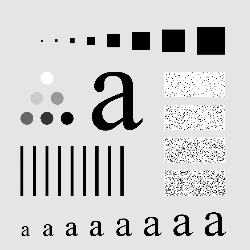

In [152]:
a = cv2.imread('img/a.tif', cv2.IMREAD_GRAYSCALE)
w, h = (500, 500)
a = cv2.resize(a, (w, h), cv2.INTER_NEAREST)
displayImage_fromcv2(a, w//2, h//2)

Aplicando los kernels de tamaño $n\times n$ del tipo
\begin{equation}
    w = \frac{1}{n^2}
    \begin{bmatrix}
    1 & 1 & ... & 1 \\
    1 & 1 & ... & 1 \\
    . & . & ... & . \\
    . & . & ... & . \\
    1 & 1 & ... & 1
    \end{bmatrix}
\end{equation}

In [153]:
window_sizes = [3,5,9,15,25,35,45,55]
a_comparison = a.copy()
for n in window_sizes:
    filtered_image = lowpass_unit_kernel(img=a, n=n)
    a_comparison = np.concatenate((a_comparison, filtered_image), axis=1)


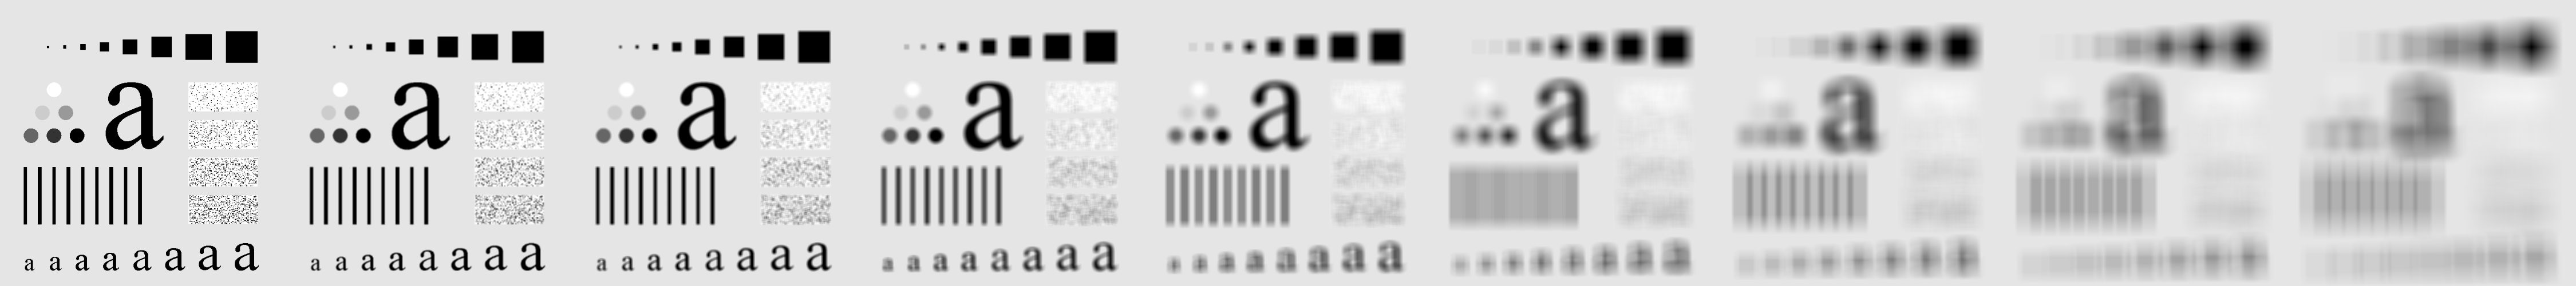

In [154]:
disp_img = Image.fromarray(a_comparison)
w, h = disp_img.size
displayImage(disp_img, w, h)

***

![ej2](img/consigna_2.png)

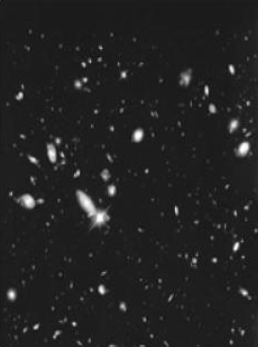

In [155]:
stars = cv2.imread('img/stars.png', cv2.IMREAD_GRAYSCALE)
h, w = stars.shape
displayImage_fromcv2(stars, w//3, h//3)

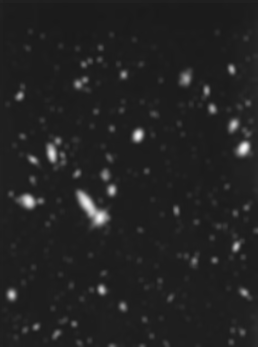

In [156]:
stars_filtered = lowpass_unit_kernel(img=stars, n=15)
displayImage_fromcv2(stars_filtered, w//3, h//3)

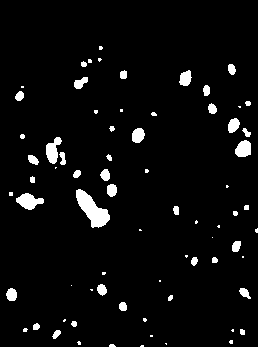

In [157]:
threshold = 0.25*np.max(stars_filtered)
stars_threshold = binary_mask(img=stars_filtered, threshold=threshold)
displayImage_fromcv2(stars_threshold, w//3, h//3)

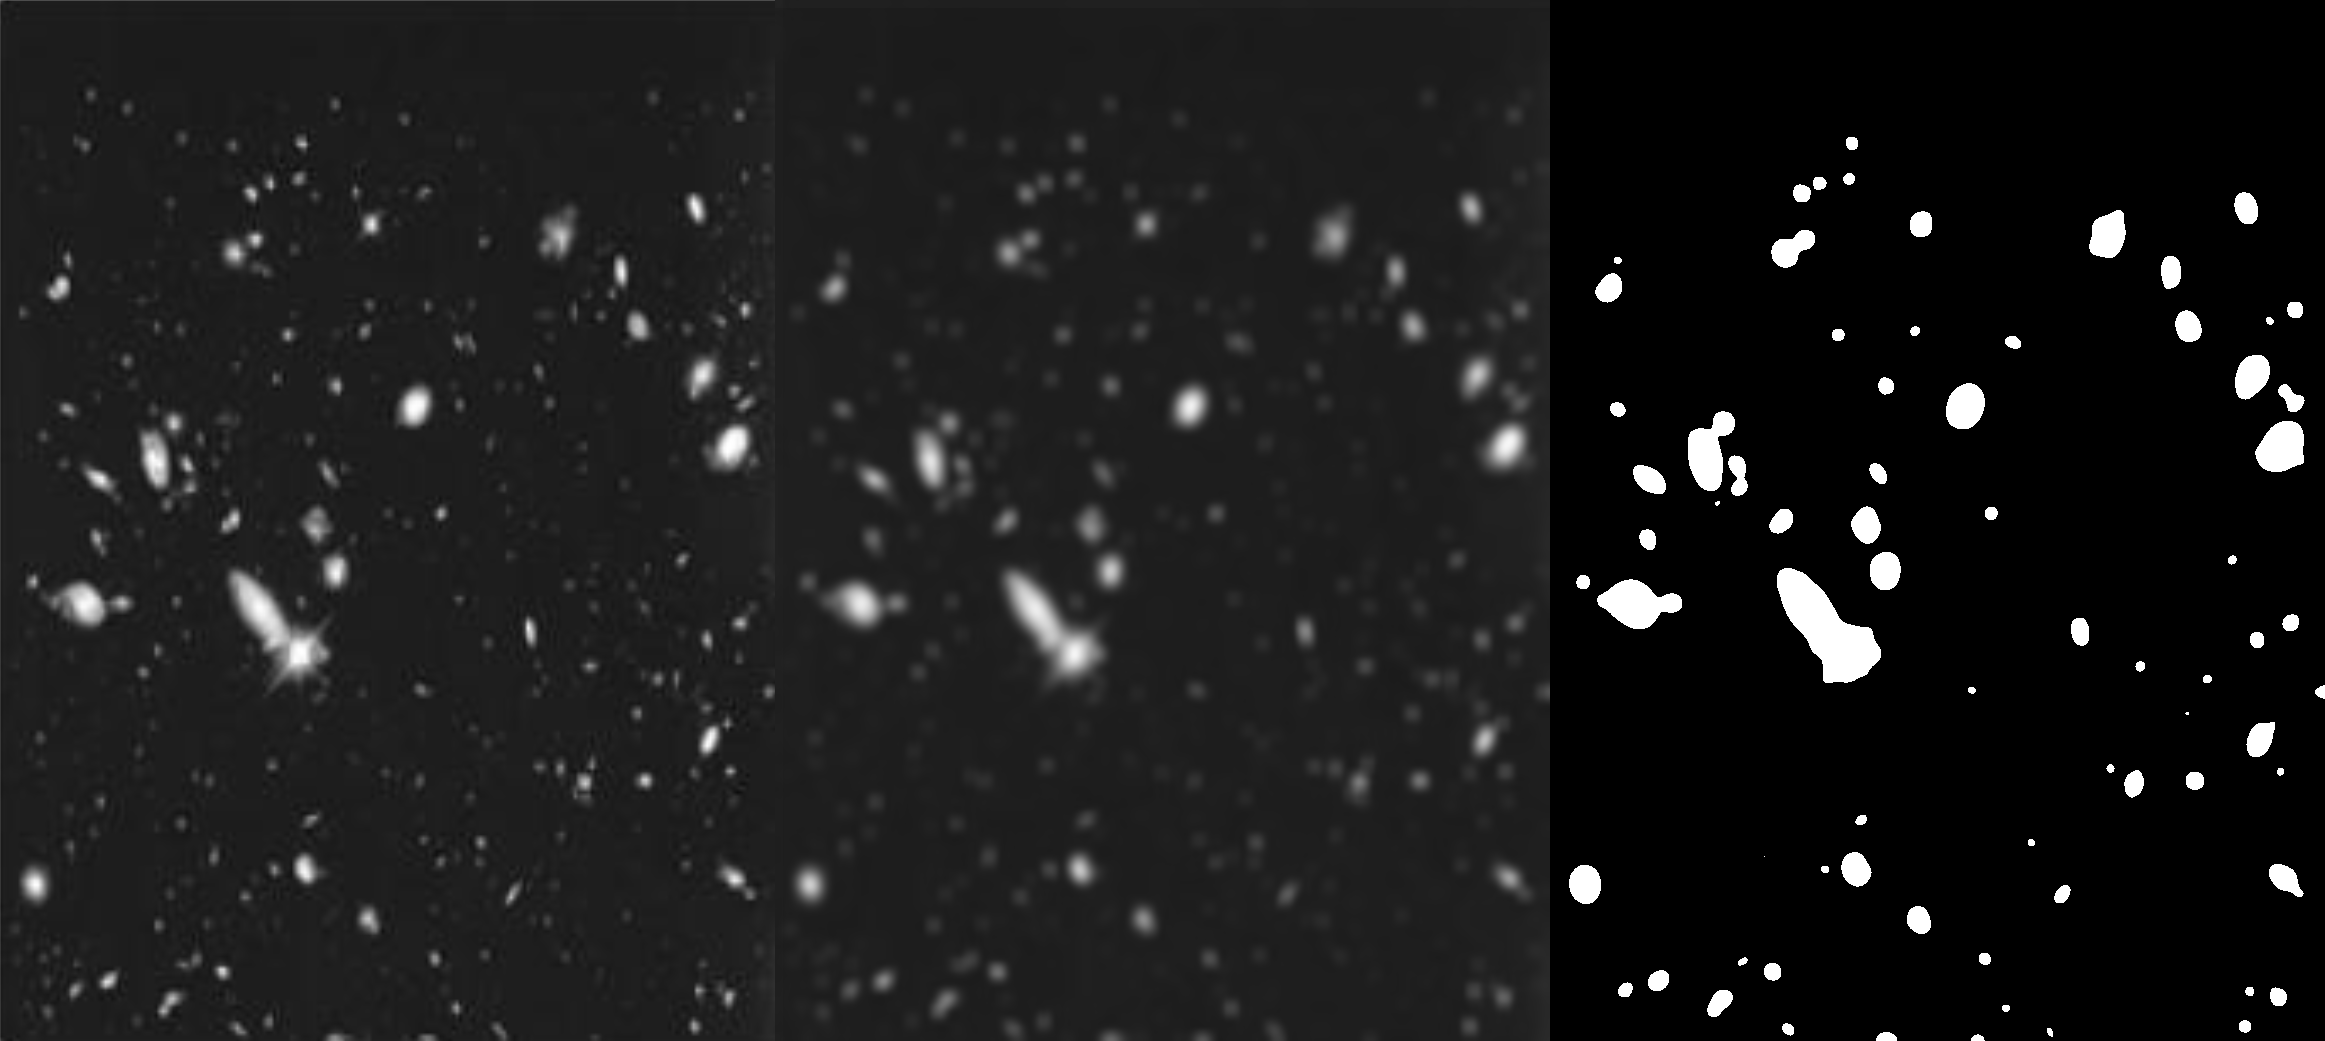

In [158]:
stars_comparison = np.concatenate((stars, stars_filtered, stars_threshold), axis=1)
displayImage_fromcv2(stars_comparison, w*3, h)

***

![ej3](img/consigna_3.png)

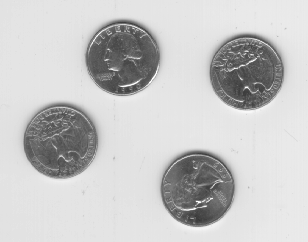

In [159]:
coins = cv2.imread('img/eight.tif', cv2.IMREAD_GRAYSCALE)
h, w = coins.shape
displayImage_fromcv2(coins, w, h)

Agregamos ruido "Salt & Pepper"

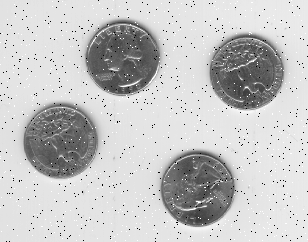

In [160]:
coins_sp = salt_and_pepper_noise(img=coins, d=0.02)
h, w = coins_sp.shape
displayImage_fromcv2(coins_sp, w, h)

Filtrado con pasa bajos

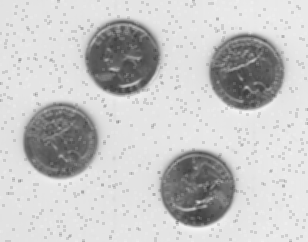

In [161]:
coins_filtered_lp = lowpass_unit_kernel(img=coins_sp, n=3)
displayImage_fromcv2(coins_filtered_lp, w, h)

Aplicando un filtro de mediana a la imagen con ruido sin LP

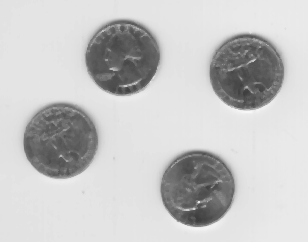

In [165]:
coins_filtered_median = cv2.medianBlur(coins_sp, 3)
displayImage_fromcv2(coins_filtered_median, w, h)

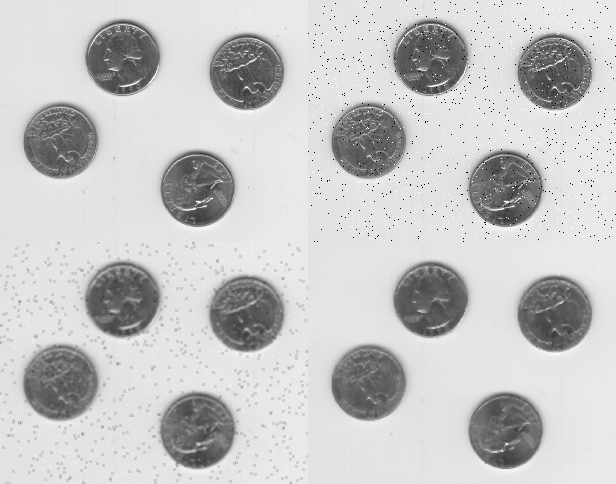

In [166]:
coins_comparison_h = np.concatenate((coins, coins_sp), axis=1)
coins_comparison_l = np.concatenate((coins_filtered_lp, coins_filtered_median), axis=1)
coins_comparison = np.concatenate((coins_comparison_h, coins_comparison_l))
displayImage_fromcv2(coins_comparison, w*2, h*2)

***

### 4. Uso del laplaciano para la recuperación del fondo sin perder la información de los bordes

***

### 5. Hi Boost

***

![ej6](img/consigna_6.png)

***

### 7. Dada la imagen lena.tif se pide obtener (usando imadjust): 
* El negativo de la imagen 
* Implementar una transformación tal que convierta los valores entre [0.25 0.5] al rango [0 1]

***

![ej8](img/consigna_8.png)

***

### 9. Realizar la medición de al menos 2 monitores (Laptop-PC) de la corrección gamma usando el fotómetro provisto por la catedra.